In [1]:
import scipy.integrate as spi
from scipy.integrate import odeint
from array import *
from scipy.optimize import curve_fit
from statistics import mean
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
#from ipynb.fs.full.HSV_Dyn_Functions import GetIndParams
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn_IS
#from ipynb.fs.full.HSV_Dyn_Functions import Vir_Dyn_DDD
#from ipynb.fs.full.HSV_Dyn_Functions import RunSimulation
#from ipynb.fs.full.HSV_Dyn_Functions import RunSimulation_DD
#from ipynb.fs.full.HSV_Dyn_Functions import Plotting
%matplotlib inline

In [2]:
def GetIndParams(Indparameters, ID, style = 'mode'):
    ''' 
    input:
        - data frame with parameter values as columns, individuals as rows
        - ID identifying individual of interest
        - style = 'mode' or 'mean' or 'SAEM' depending on which parameter values are preferred
    return:
        - dictionary with parameter names as key and parameter values as values
    '''
    i = ID
    cols = list(Indparameters)
    pid_params = Indparameters[Indparameters.id == i]
  #  print(pid_params)
    values = []
    keys = []
    for c in cols:
        if style in c:
            k = c.split('_')[0]
            keys.append(k)
            v = pid_params[c].values[0]
            values.append(v)
        for i,(v,k) in enumerate(zip(values, keys)):
            if 'log10' in k:
                values[i] = 10**v
                keys[i] = k.split('0')[1]
    if 'alpha' in keys:
        i = keys.index('alpha')
        j = keys.index('kPL')
        values[j] = values[j]*dose**values[i]

    params = dict(zip(keys, values))
    return params

In [3]:
def RunSimulation_Szero(Vir_Dyn, Data, Indparameters, param_order, id, C_Tot, nk, N, VCell0, VSup0):
    Params_dict = GetIndParams(Indparameters, id, style = 'mode')
    print(Params_dict)
    params = []
    for k in param_order:
        params.append(Params_dict[k])
    params.append(nk)
    print(params)
    MOI = Data[Data.ID == id].MOI.unique()[0]
    Init = Params_dict['Szero'], C_Tot-Params_dict['Szero']
    for i in range(1,nk):
        Init = np.append(Init, 0)
    Init = np.append(Init, [0, VCell0, VSup0])

    #print(Init)
    t = np.linspace(0, max(Data.time), N)
    y = spi.odeint(Vir_Dyn, Init, t, args = tuple(params))  
    return y.T

In [4]:
def Vir_Dyn_betaSup0(y,t, betaCell, piCell, D, k, gamma, nk):
    dY = np.zeros(nk+4);
    E = np.zeros(nk)
    S = y[0]
    for i in range(1, nk+1):
        E[i-1] = y[i]
    I = y[nk+1]
    V_Cell = y[nk+2]
    V_Sup = y[nk+3]

    dY[0] = -betaCell*V_Cell*S
    dY[1] = betaCell*V_Cell*S - k*E[0]
    for i in range(2, nk+1):
        dY[i] = k*(E[i-2]-E[i-1])
    dY[nk+1] = k*E[nk-1]
    dY[nk+2] = piCell*I - D*V_Cell
    dY[nk+3] = D*V_Cell - gamma*V_Sup
    
    
    return dY

In [5]:
data_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/HSV cell culture kinetics/Projects/Data/Marius Data/qPCR_Time_course_N2A.csv'


Data = pd.read_csv(data_file)

IDs = Data.ID.unique()
print(Data)
print(IDs)

      ID  time       qPCR_1       qPCR_2       AveqPCR  log10_AverPCR ObsID  \
0   High     1     18139950     35286890  2.671342e+07       7.426729  Cell   
1   High     6     32230590    246662185  1.394464e+08       8.144407  Cell   
2   High    12   2480987500    242700325  1.361844e+09       9.134127  Cell   
3   High    24   3082558000   5958479500  4.520519e+09       9.655188  Cell   
4   High    30   7646697500   9385589000  8.516143e+09       9.930243  Cell   
5   High    36   6342647500  45484300000  2.591347e+10      10.413526  Cell   
6   High    48   8303655000  48288920000  2.829629e+10      10.451729  Cell   
7   High    60  11858607000  12306976000  1.208279e+10      10.082167  Cell   
8   High     1      1660260      5280040  3.470150e+06       6.540348   Sup   
9   High     6     43937195     55848625  4.989291e+07       7.698039   Sup   
10  High    12      6657745     67798715  3.722823e+07       7.570872   Sup   
11  High    24    279258590    227662965  2.534608e+

In [7]:
Indparameters_file_nk_1_betaSup0 = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/HSV cell culture kinetics/Projects/N2A/HSV_Regressor_AVE_qPCR_N2A_deltaI=0_InitfrmData_nk=1_betaSup0_extExplor/IndividualParameters/estimatedIndividualParameters.txt'


Indparameters_Lin01 = pd.read_csv(Indparameters_file_nk_1_betaSup0)
print(Indparameters_Lin01)
#i = Data.ID == 'High1'
#j= Data.ObsID == 'Cell'
#print(Data[(Data.ID == 'Low1') & (Data.ObsID == 'Cell')].moi.unique())
#print(Data[Data.ID.index == 'High1' & Data.ObsID.index == 'Cell'].qPCR)

     id  piCell_SAEM    D_SAEM  gamma_SAEM  log10betaCell_SAEM  kappa_SAEM  \
0  High      1039.35  0.008270        0.04            -11.0259    0.023914   
1   Low      1038.42  0.008139        0.04            -11.0267    0.023900   

   Szero_SAEM  piCell_mean    D_mean  gamma_mean  ...  log10betaCell_mode  \
0     11867.1      1041.74  0.008260        0.04  ...            -11.0244   
1    973980.0      1040.01  0.008181        0.04  ...            -11.0247   

   kappa_mode  Szero_mode  piCell_sd      D_sd  gamma_sd  log10betaCell_sd  \
0    0.023762     11869.3    29.6774  0.000441         0          0.031761   
1    0.023748    974109.0    28.3118  0.000436         0          0.031375   

   kappa_sd  Szero_sd  MOI  
0  0.000681   10.8844  3.0  
1  0.000644  898.3680  0.1  

[2 rows x 26 columns]


In [8]:
param_order = ['betaCell', 'piCell', 'D', 'kappa', 'gamma']
C_Tot = 1000000
nk = 1
N = 10000 #timesteps
#i = 1
E_01 = np.zeros((len(IDs),nk, N))
for id, idi in zip(IDs, range(0,len(IDs))):
    VCell0 = float(Data[(Data.ID == id) & 
                                 (Data.time == 1) & 
                                 (Data.ObsID == 'Cell')].AveqPCR)

    VSup0 = float(Data[(Data.ID == id) & 
                                 (Data.time == 1) & 
                                 (Data.ObsID == 'Sup')].AveqPCR)

    y = RunSimulation_Szero(Vir_Dyn_betaSup0, Data, Indparameters_Lin01, param_order, id, C_Tot, nk, N,VCell0, VSup0)

    if id == IDs[0]:
        S_01 = y[0,:]
        for i in range(1, nk+1):
            E_01[idi,i-1,:] = y[i,:]
        I_01 = y[nk+1,:]
        V_Cell_01 = y[nk+2,:]
        V_Sup_01 = y[nk+3,:]

        
    else:
        S_01 = np.vstack((S_01,y[0,:]))
        for i in range(1, nk+1):
            E_01[idi,i-1,:] = y[i,:]
        I_01 = np.vstack((I_01,y[nk+1,:]))
        V_Cell_01 = np.vstack((V_Cell_01,y[nk+2,:]))
        V_Sup_01 = np.vstack((V_Sup_01,y[nk+3,:]))


{'piCell': 1040.95, 'D': 0.00825771, 'gamma': 0.04, 'betaCell': 9.453660459579653e-12, 'kappa': 0.0237623, 'Szero': 11869.3}
[9.453660459579653e-12, 1040.95, 0.00825771, 0.0237623, 0.04, 1]
{'piCell': 1039.62, 'D': 0.00814856, 'gamma': 0.04, 'betaCell': 9.447132357271376e-12, 'kappa': 0.0237477, 'Szero': 974109.0}
[9.447132357271376e-12, 1039.62, 0.00814856, 0.0237477, 0.04, 1]


In [9]:
S_01[1]

array([9.74109000e+05, 9.74108826e+05, 9.74108652e+05, ...,
       1.28653642e+02, 1.28147639e+02, 1.27643483e+02])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


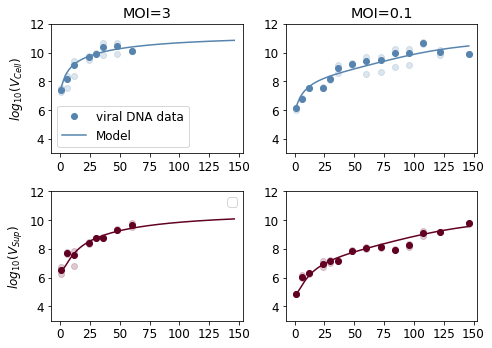

In [10]:
fig = plt.figure(figsize = (7,5))
plt.rcParams.update({'font.size': 12})
for id, idi in zip(IDs, range(0,len(IDs))):
    t_Celldata = Data[(Data.ID == id) & (Data.ObsID == 'Cell')].time
    temp = Data[(Data.ID == id) & (Data.ObsID == 'Cell')].log10_AverPCR
    y_Cell_1_PCR = Data[(Data.ID == id) & (Data.ObsID == 'Cell')].qPCR_1
    y_Cell_2_PCR = Data[(Data.ID == id) & (Data.ObsID == 'Cell')].qPCR_2
    y_Celldata = [float(y) for y in temp]
    #print(temp)
    t_Supdata = Data[(Data.ID == id) & (Data.ObsID == 'Sup')].time
    temp = Data[(Data.ID == id) & (Data.ObsID == 'Sup')].log10_AverPCR
    y_Sup_1_PCR = Data[(Data.ID == id) & (Data.ObsID == 'Sup')].qPCR_1
    y_Sup_2_PCR = Data[(Data.ID == id) & (Data.ObsID == 'Sup')].qPCR_2
    y_Supdata = [float(y) for y in temp]    

    t = np.linspace(0, max(Data.time), N)
    plt.subplot(2,2,idi+1)
    plt.plot(t_Celldata.values, np.log10(y_Cell_1_PCR),'o', alpha = 0.2,  color = 'xkcd:off blue')
    plt.plot(t_Celldata.values, np.log10(y_Cell_2_PCR),'o', alpha = 0.2,  color = 'xkcd:off blue')
    plt.plot(t_Celldata.values, y_Celldata,'o', color = 'xkcd:off blue', label = 'viral DNA data')

    plt.plot(t,np.log10(V_Cell_01[idi,:]), label = 'Model', color = 'xkcd:off blue')
   
    if id=='High':
        plt.title('MOI=3')
    else:
        plt.title('MOI=0.1')
    if idi ==0:
        plt.ylabel('$log_{10}(V_{Cell})$')
        plt.legend()
    plt.ylim([3, 12])
    plt.xticks(np.linspace(0,150,7))
    plt.subplot(2,2,idi+3)
    plt.plot(t_Supdata.values, np.log10(y_Sup_1_PCR),'o', alpha = 0.2,  color = 'xkcd:burgundy')
    plt.plot(t_Supdata.values, np.log10(y_Sup_2_PCR),'o', alpha = 0.2,  color = 'xkcd:burgundy')
    plt.plot(t_Supdata.values, y_Supdata,'o', color = 'xkcd:burgundy')

    plt.plot(t,np.log10(V_Sup_01[idi,:]),color = 'xkcd:burgundy')
  
    if idi ==0:
        plt.ylabel('$log_{10}(V_{Sup})$')
        plt.legend()
    plt.ylim([3, 12])
    plt.xticks(np.linspace(0,150,7))
plt.tight_layout()
#plt.savefig('Figures/FittoAve_nk=1VS3.svg')
#plt.savefig('Figures/FittoAve_nk=1VS3.png')

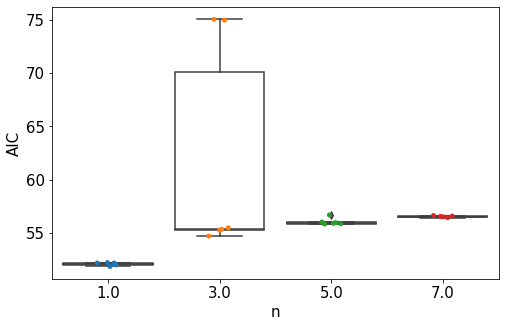

In [11]:
AIC_File = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/HSV cell culture kinetics/Projects/N2A/HSVModelAIC_2VirComp.csv'
AIC_DF = pd.read_csv(AIC_File)
#print(AIC_DF[AIC_DF.Model=='DD Diff'])
#print(AIC_DF[AIC_DF.Model=='Linear Diff'])
fig = plt.figure(figsize = (8,5))
plt.rcParams.update({'font.size': 15})
#plt.subplot(2,1,1)
ax = sns.stripplot(data = AIC_DF[AIC_DF.Model=='Linear Diff'], x = 'n', y = "AIC")
ax = sns.boxplot(data = AIC_DF[AIC_DF.Model=='Linear Diff'], x = 'n', y = "AIC")
#for p in ax.patches:
#    mybox =p
#    color = mybox.get_facecolor()
#    mybox.set_facecolor((0, 0, 0, 0))
   # mybox.set_edgecolor('black')
#plt.ylim([10,75])
#plt.title('Constant Egress Rate')
#plt.subplot(2,1,2)

for p in ax.patches:
    mybox =p
    color = mybox.get_facecolor()
    mybox.set_facecolor((0, 0, 0, 0))
#plt.title('Density-Dependent Egress Rate')
#plt.ylim([11,18])
#plt.tight_layout()
#plt.savefig()

/var/folders/z2/v4k5h92d3x34xw1wf5f8b_nh0000gp/T/ipykernel_24881/3587120383.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, 1500000])
/var/folders/z2/v4k5h92d3x34xw1wf5f8b_nh0000gp/T/ipykernel_24881/3587120383.py:19: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, 1500000])
/var/folders/z2/v4k5h92d3x34xw1wf5f8b_nh0000gp/T/ipykernel_24881/3587120383.py:26: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, 1500000])
/var/folders/z2/v4k5h92d3x34xw1wf5f8b_nh0000gp/T/ipykernel_24881/3587120383.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, 1500000])
/var/folders/z2/v4k5h92d3x34xw1wf5f8b_nh0000gp/T/ipykernel_24881/3587120383.py:19: UserWarning: Attempted to set non-positive bottom yli

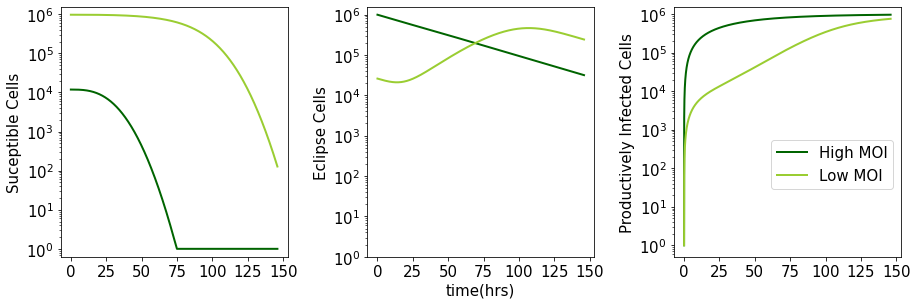

In [15]:
fig = plt.figure(figsize = (13,4.5))
plt.rcParams.update({'font.size': 15})
color = ['darkgreen', 'yellowgreen']
for id, idi in zip(IDs, range(0,len(IDs))):
   

    t = np.linspace(0, max(Data.time), N)
    plt.subplot(1,3,1)
    plt.semilogy(t,np.maximum(S_01[idi,:],1), linewidth = 2, color = color[idi])
    plt.ylabel('Suceptible Cells')
    plt.ylim([0, 1500000])
    plt.yticks([1,10,100,1000,10000,100000, 1000000])
    plt.xticks(np.linspace(0,150,7))
    
    plt.subplot(1,3,2)
    plt.semilogy(t,np.maximum(E_01[idi,0, :],1), linewidth = 2, color = color[idi])
    plt.ylabel('Eclipse Cells')
    plt.xticks(np.linspace(0,150,7))
    plt.ylim([0, 1500000])
    plt.yticks([1,10,100,1000,10000,100000, 1000000])
    plt.xlabel('time(hrs)')

    plt.subplot(1,3,3)
    plt.semilogy(t,np.maximum(I_01[idi, :],1), linewidth = 2, color = color[idi], label = str(id)+ ' MOI')
    plt.ylabel('Productively Infected Cells')
    plt.ylim([0, 1500000])
    plt.yticks([1,10,100,1000,10000,100000, 1000000])
    plt.xticks(np.linspace(0,150,7))
    
plt.legend(bbox_to_anchor=(1, 0.5))
plt.tight_layout()
